In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

import patsy
import statsmodels.api as sm

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway


## Loading in data

In [5]:
df = pd.read_excel('data/tech_layoffs.xlsx')
df.head()

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [6]:
df.dtypes

#                                       int64
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                                int64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs             int64
Company_Size_after_layoffs              int64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                  object
Year                                    int64
lat                                   float64
lng                                   float64
dtype: object

In [7]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

#### Company Size
Now, let's ask the following question: Does the size of the company affect the percentage of employees that the company will lay off? 

Determining if there is a relationship between the size of the company before layoffs and the percentage of employees that were laid off can be useful in understanding the factors that affect layoffs. In order to answer the question above, let's first look at the distributions for the company size before layoffs and the percentage of employees that were laid off.

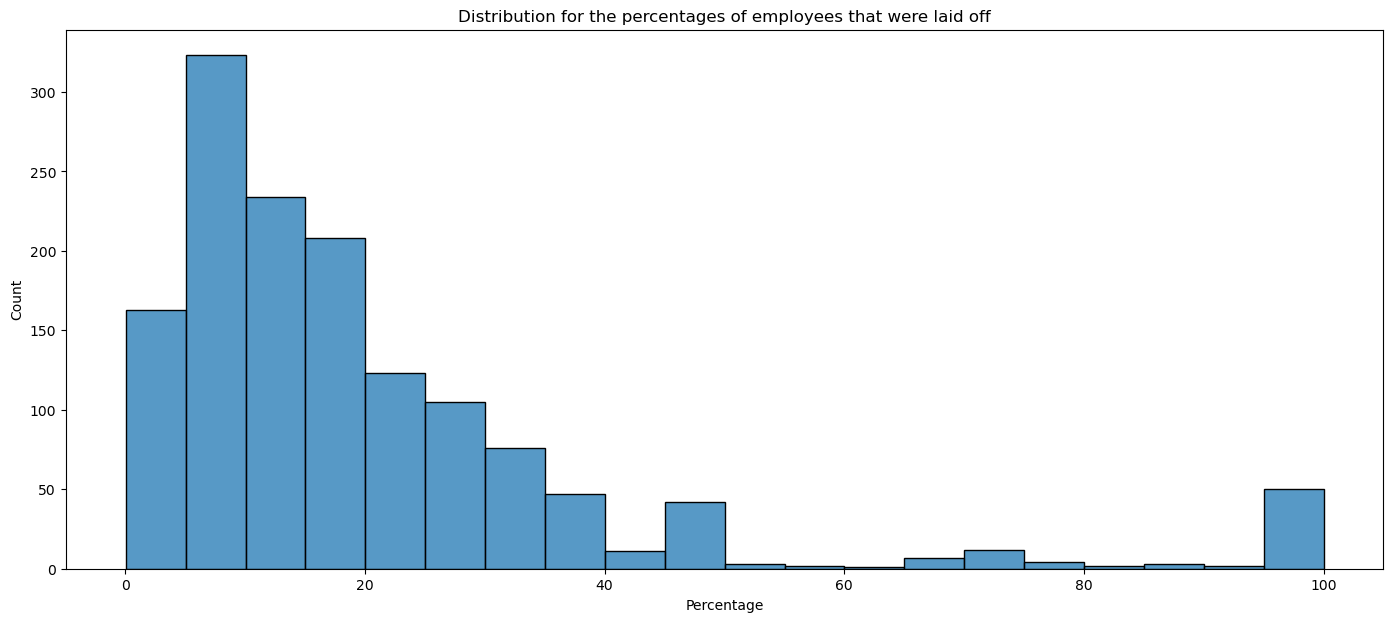

In [8]:
sns.histplot(df['Percentage'], bins=20)
plt.title('Distribution for the percentages of employees that were laid off');

In [9]:
df.sort_values(by='Percentage', ascending=False).head(10)

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Funding
1417,3290,Frontdesk,Milwaukee,USA,North America,200,2024-02-01,100.0,200,0,Travel,Unknown,$26,2024,43.03890,-87.90647,26.0
1067,2629,Pocketmath,Singapore,Singapore,Asia,21,2021-01-20,100.0,21,0,Marketing,Unknown,$20,2021,1.28967,103.85007,20.0
1061,2606,Katerra,San Francisco Bay Area,USA,North America,2434,2021-06-01,100.0,2434,0,Construction,Unknown,$1600,2021,37.45383,-122.18219,1600.0
1031,2544,Ahead,San Francisco Bay Area,USA,North America,44,2022-04-14,100.0,44,0,Healthcare,Unknown,$9,2022,37.77493,-122.41942,9.0
84,323,Dealtale,Tel Aviv,Israel,Asia,70,2023-08-09,100.0,70,0,Sales,Acquired,$2,2023,32.08088,34.78057,2.0
995,2482,BeyondMinds,Tel Aviv,Israel,Asia,65,2022-05-23,100.0,65,0,Data,Series A,$16,2022,32.08088,34.78057,16.0
973,2438,Udayy,Gurugram,India,Asia,100,2022-06-01,100.0,100,0,Education,Seed,$2,2022,28.46010,77.02635,2.0
952,2390,The Grommet,Boston,USA,North America,40,2022-06-09,100.0,40,0,Retail,Acquired,$5,2022,42.35843,-71.05977,5.0
913,2333,SummerBio,San Francisco Bay Area,USA,North America,101,2022-06-20,100.0,101,0,Healthcare,Unknown,$7,2022,37.45383,-122.18219,7.0
870,2252,Crejo.Fun,Bengaluru,India,Asia,170,2022-06-30,100.0,170,0,Education,Seed,$3,2022,12.97194,77.59369,3.0


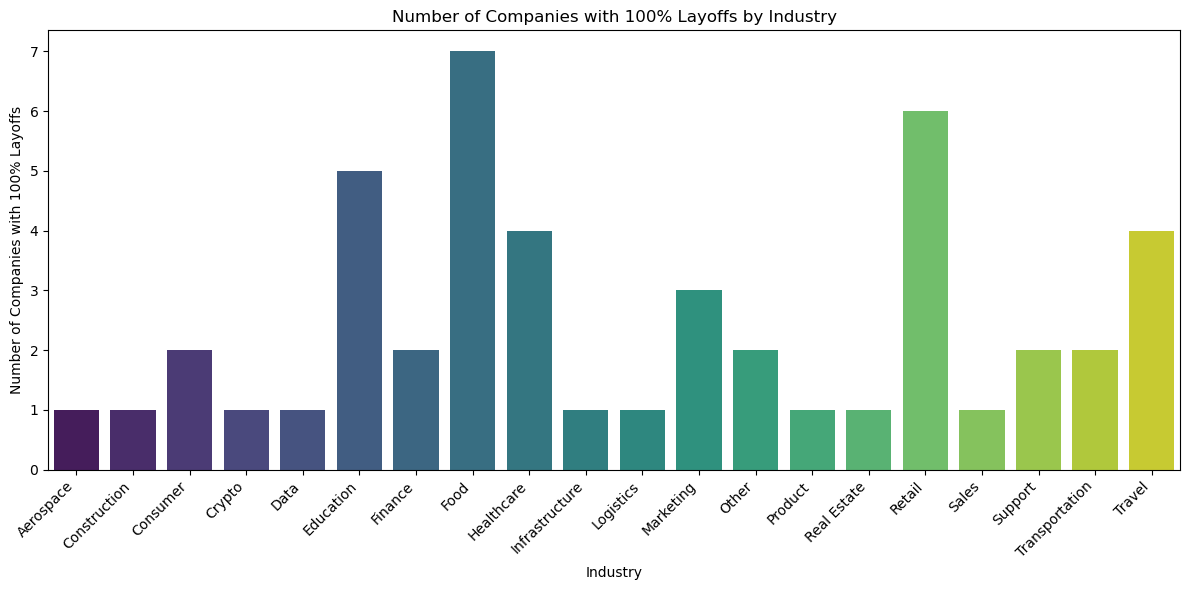

In [10]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Group the filtered DataFrame by the 'Industry' column and count the number of companies in each group
companies_count_by_industry = companies_with_100_percentage.groupby('Industry').size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=companies_count_by_industry, x='Industry', y='Count', hue='Industry', palette='viridis')
plt.xlabel('Industry')
plt.ylabel('Number of Companies with 100% Layoffs')
plt.title('Number of Companies with 100% Layoffs by Industry')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

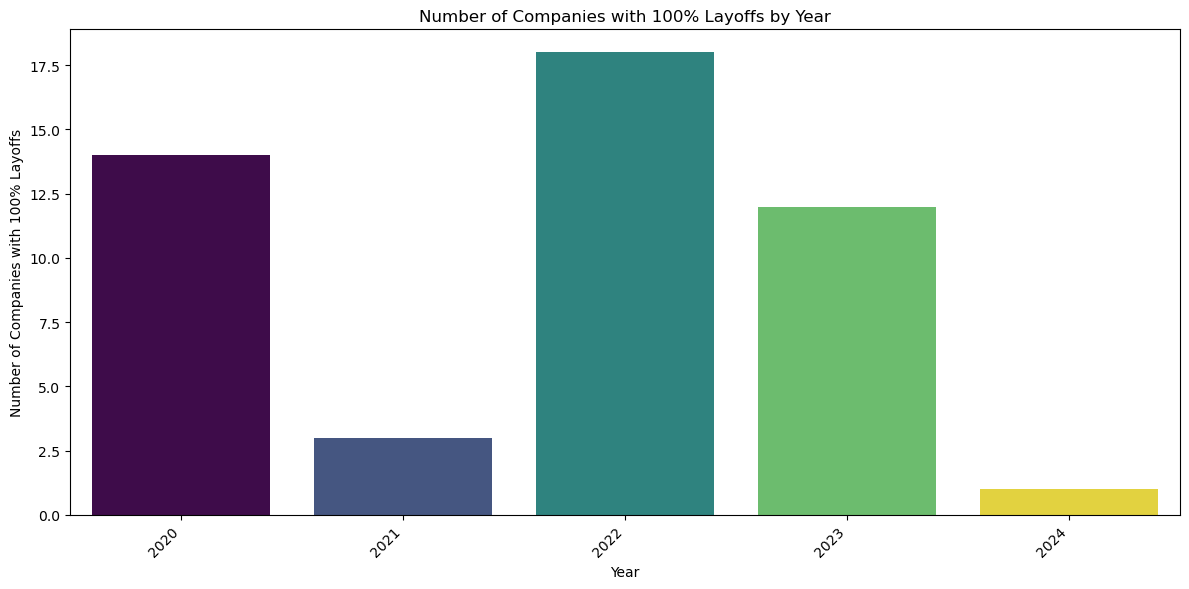

In [11]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Group the filtered DataFrame by the 'Year' column and count the number of companies in each group
companies_count_by_year = companies_with_100_percentage.groupby('Year').size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=companies_count_by_year, x='Year', y='Count', hue='Year', palette='viridis', legend=None)
plt.xlabel('Year')
plt.ylabel('Number of Companies with 100% Layoffs')
plt.title('Number of Companies with 100% Layoffs by Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Filter the DataFrame to include only rows where the 'Percentage' column equals 100
companies_with_100_percentage = df[df['Percentage'] == 100]

# Separate the company size for 100% layoffs for each year
company_size_by_year = [companies_with_100_percentage[companies_with_100_percentage['Year'] == year]['Company_Size_before_Layoffs'] 
                        for year in df['Year'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*company_size_by_year)

# Print the ANOVA results
print("ANOVA Results:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)


ANOVA Results:
F-statistic: 2.1863652452746707
P-value: 0.08654579753082588


In [13]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Separate the company size for 100% layoffs and for each year
company_size_100_percent = companies_with_100_percentage['Company_Size_before_Layoffs']
company_size_by_year = [df[df['Year'] == year]['Company_Size_before_Layoffs'] for year in df['Year'].unique()]

# Perform t-tests for each year
for year, company_size_year in zip(df['Year'].unique(), company_size_by_year):
    t_statistic, p_value = ttest_ind(company_size_100_percent, company_size_year)
    print(f"T-test Results for Year {year}:")
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)
    print()

T-test Results for Year 2023:
T-statistic: -1.2001023747101556
P-value: 0.2306439507537573

T-test Results for Year 2022:
T-statistic: -0.9728564125161134
P-value: 0.3310010299059366

T-test Results for Year 2021:
T-statistic: -4.45056325719295
P-value: 3.782074114996237e-05

T-test Results for Year 2020:
T-statistic: -1.8462070327884963
P-value: 0.06564171777468955

T-test Results for Year 2024:
T-statistic: -1.90947640714304
P-value: 0.06083046782571632



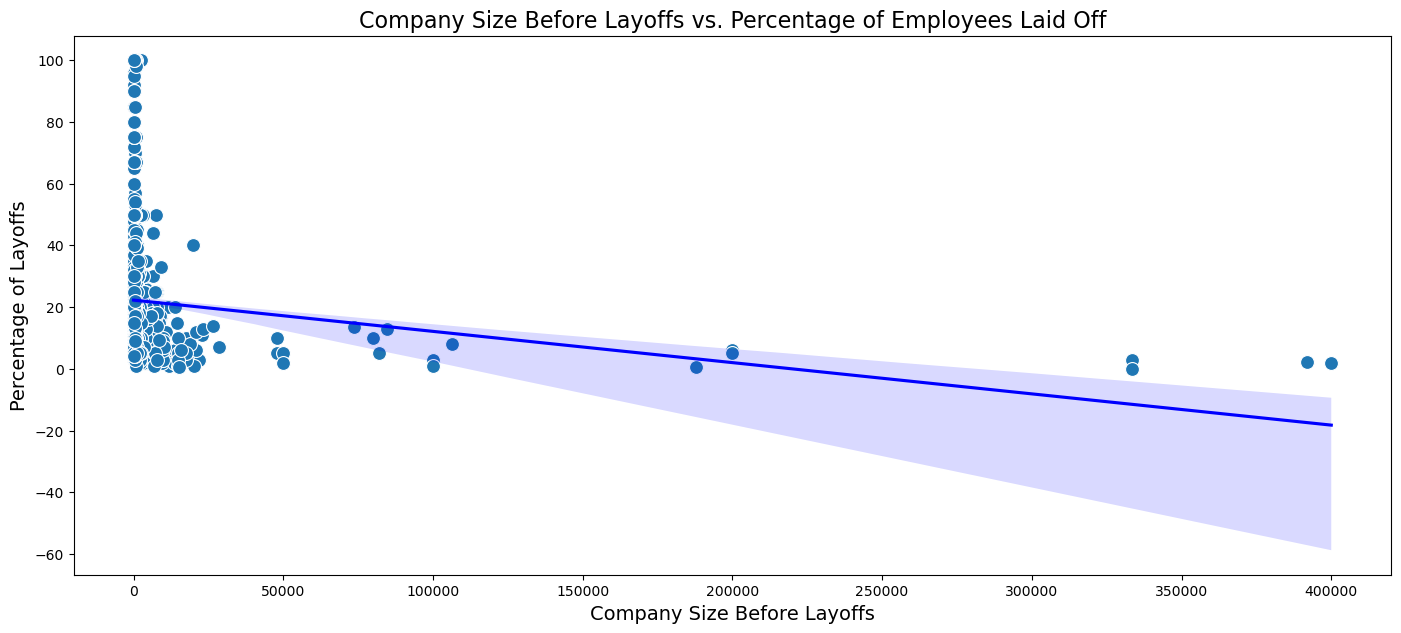

In [14]:
# Plotting scatterplot comparing Company_Size_before_Layoffs and Percentage laid off
sns.scatterplot(x='Company_Size_before_Layoffs', y='Percentage', data=df, s=100);

# Plotting line of best fit
sns.regplot(x='Company_Size_before_Layoffs', y='Percentage', data=df, scatter=False, color='blue')

plt.title('Company Size Before Layoffs vs. Percentage of Employees Laid Off', fontsize=16)
plt.xlabel('Company Size Before Layoffs', fontsize=14)
plt.ylabel('Percentage of Layoffs', fontsize=14)
plt.show()


According to this scatterplot, as the company size before layoffs increases, the percentage of layoffs decreases. Let's perform the OLS Regression analysis to see whether there is a significant relationship between company size before layoffs and the percentage of layoffs.

In [15]:
outcome, predictors = patsy.dmatrices('Percentage ~ Company_Size_before_Layoffs', df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Percentage   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     17.40
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           3.21e-05
Time:                        13:32:33   Log-Likelihood:                -6297.0
No. Observations:                1418   AIC:                         1.260e+04
Df Residuals:                    1416   BIC:                         1.261e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Based on the table above, the intercept is 22.2617, which means that if the company size before layoffs is 0, the percentage of layoffs would be 22.2617, which in this case doesn't add much value to the analysis since company size cannot be zero in practical terms. The effect size is -.0001, which means that for every 1 unit increase in company size before layoffs, you expect to see a 0.0001 unit decrease in the percentage of employees laid off. Hence, there is a negative relationship between company size before layoffs and the percentage of employees laid off, meaning as the company size before layoffs increases, the percentage of employees laid off decreases. This makes sense because compared to smaller companies, if larger companies layoff more people than smaller companies, the percentage is not going to be as high since larger companies have more employees to begin with. Both the intercept and the coefficient for company size before layoffs have statistically significant p-values (P < 0.05), indicating that larger company sizes before layoffs are associated with lower percentages. However, the effect size is relatively small. 

Now, let's see what the correlation coefficient is for company size before layoffs and the percentages of layoffs.

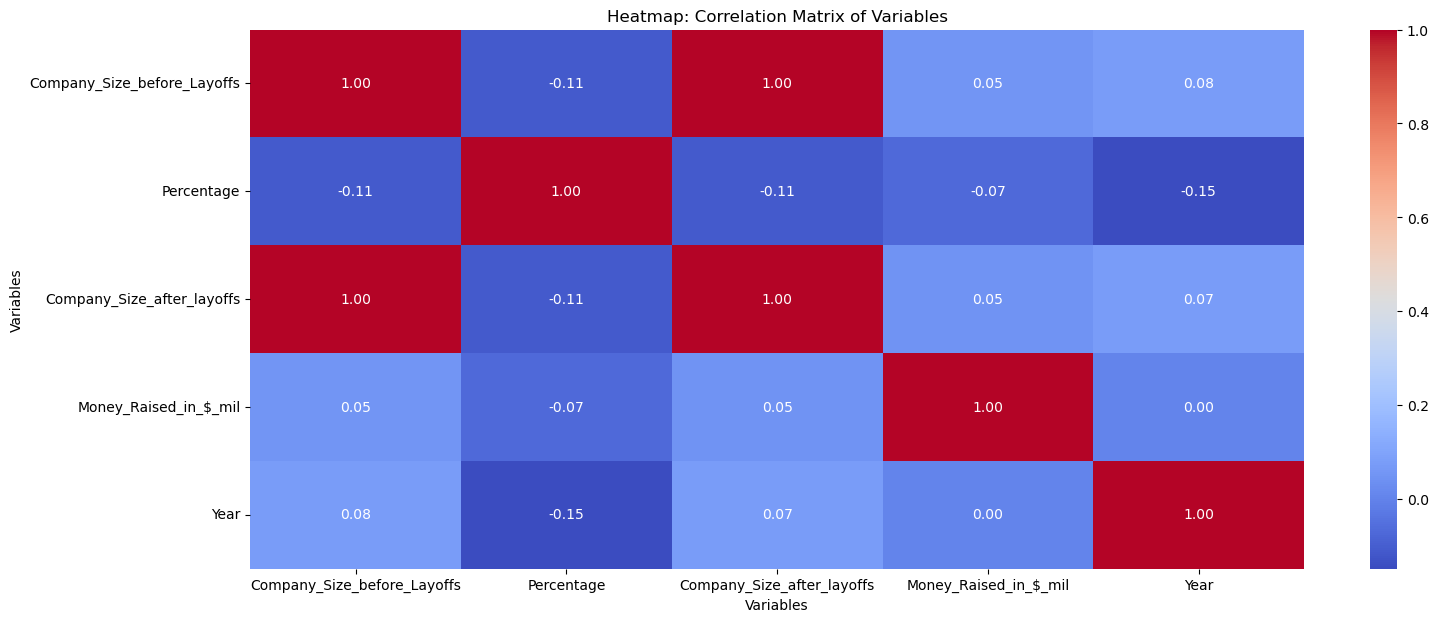

In [22]:
df['Money_Raised_in_$_mil'] = df['Money_Raised_in_$_mil'].str.replace('$', '')

heatmap_data = df[['Company_Size_before_Layoffs', 'Percentage', 'Company_Size_after_layoffs', 'Money_Raised_in_$_mil', 'Year']]

# Create the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add labels and title
plt.title('Heatmap: Correlation Matrix of Variables')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show plot
plt.show()

According to this heat map, there is a weak negative correlation between company size before layoffs and the percentage of layoffs (r = -0.11). This suggests that the company size before layoffs has only a minor impact on the percentage of layoffs. It seems that the correlation coefficient is higher for the year and the percentages of layoffs. It will be interesting to see whether the effect size is higher (and statistically significant) for these two variables.

In [17]:
#T test for company size before layoffs and percentage of layoffs
company_size_before_layoffs = df['Company_Size_before_Layoffs']
percentage = df['Percentage']

# Perform t-test
t_statistic, p_value = ttest_ind(company_size_before_layoffs, percentage)

# Print the t-test results
print("T-test Results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-test Results:
T-statistic: 5.920793709581646
P-value: 3.5893485327245783e-09


In this case, since the p-value is very small (3.5893485327245788e-09), we reject the null hypothesis and conclude that there is a significant difference between the company size before layoffs and the percentage of layoffs.